In [69]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
nltk.download('stopwords')
from nltk.corpus import stopwords
import os
import os.path
import re
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

import requests
from summa.summarizer import summarize

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
67237,Sasikala's parole plea rejected over inadequacies,Expelled AIADMK leader VK Sasikala's parole pl...
36948,BJP leader shot dead in Tripura by unknown ass...,BJP leader Biswajit Pal was shot dead by unkno...
38890,Singapore to spend Ã¢ÂÂ¹100 crore for Trump-K...,Singapore Prime Minister Lee Hsien Loong on Su...
47185,Salman wants Arijit's song removed from Johar'...,"As per reports, Salman Khan has asked makers t..."
42295,Intelligence Bureau transfers 500 officers,The Intelligence Bureau has transferred around...
9885,"India could've built more schools, homes than ...",World champion Lewis Hamilton has clarified on...
40744,"Petition against MoS status to Computer baba, ...",A petition has been filed against the Madhya P...
35816,IIT-Delhi asks for undertaking against drinkin...,The IIT-Delhi administration has decided to ma...
96149,MCD polls: HC rejects Swaraj India's plea for ...,"Ahead of the MCD polls, the Delhi High Court o..."
36893,God wanted Trump to become President: White House,White House Press Secretary Sarah Sanders has ...


In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [19]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").get_text(separator=" ") # <br />, <a href = ...> 등의 html 태그 공백으로 치환
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
# temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered wasasdas<br />for my mother and father.'
# temp_summary = 'Great way to start (or finish) the day!!!'

# print("text: ", preprocess_sentence(temp_text))
# print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasasdas mother father
summary: great way to start the day


In [27]:
#데이터 전처리가 오래걸려 파일로 저장 및 불러오기
def load_processedData() :
    file = 'data.pkl'     # 예제 Textfile
    if os.path.isfile(file):
        dt = pd.read_pickle(file)
    else :
        dt = preprocess()
        dt.to_pickle(file)
    return dt

        

In [29]:
def preprocess() :
    dt = data
    clean_text = []
    for index, row in data.iterrows():
        clean_text.append(preprocess_sentence(row['text']))
    print("Text 전처리 후 결과: ", clean_text[:5])
    
    clean_summary = []
    for index, row in dt.iterrows():
        clean_summary.append(preprocess_sentence(row['headlines'],False))
    print("headlines 전처리 후 결과: ", clean_summary[:5])
    dt['text'] = clean_text
    dt['headlines'] = clean_summary
    # 빈 값을 Null 값으로 변환
    dt.replace('', np.nan, inplace=True)
    dt.dropna(axis=0, inplace=True)
    return dt

In [32]:
data = load_processedData()

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


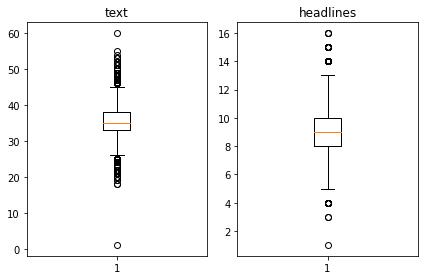

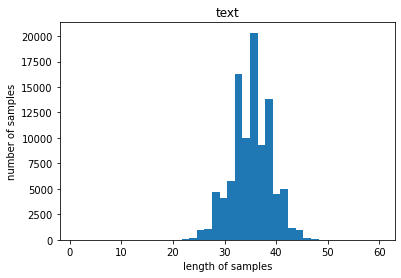

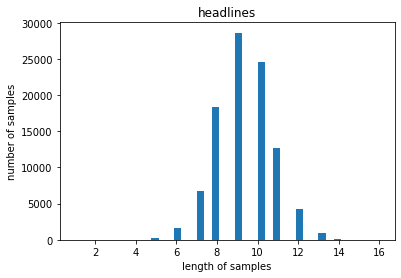

In [33]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
#최대길이가 크지 않고 편차도 크지 않으므로 그대로 사용한다.
text_max_len = 60
summary_max_len = 16
print('=3')

=3


In [38]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [39]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [40]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[43763 97034 55175 ... 49483 54532  1970]


In [41]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [148]:
# src_tokenizer.texts_to_sequences(encoder_input[50])
encoder_input[50]
src_tokenizer.texts_to_sequences([encoder_input[50]])

[[208,
  1474,
  75,
  657,
  1603,
  3,
  11,
  985,
  329,
  1337,
  405,
  228,
  413,
  330,
  1750,
  139,
  466,
  948,
  1283,
  1931,
  10271,
  377,
  762,
  466,
  732]]

In [42]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [43]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [44]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [45]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69762
등장 빈도가 6번 이하인 희귀 단어의 수: 47521
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22241
단어 집합에서 희귀 단어의 비율: 68.11874659556779
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4740237522570294


In [46]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [47]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[8583, 74, 1595, 1072, 1154, 10266, 3173, 2525, 10266, 3114, 11, 1401, 345, 671, 80, 963, 92, 1595, 1072, 10266, 200, 1216, 1072, 29, 3, 74, 2225, 1148, 10266, 27, 2225, 2595, 10266], [1532, 209, 33, 9312, 56, 1460, 277, 1396, 1261, 1511, 3924, 877, 471, 1279, 10, 16700, 8974, 471, 2059, 15320, 277, 1120, 2201, 3224, 8438, 1790, 105, 6, 544, 5535, 4938], [292, 470, 1250, 1128, 18, 6895, 988, 831, 2191, 1250, 302, 5339, 4373, 15321, 10994, 5340, 3294, 203, 6566, 9681, 189, 218, 7, 376, 6895, 33, 3, 503, 200, 18, 2346, 701, 1049, 155, 662, 126, 2346, 376]]


In [48]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [50]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30104
등장 빈도가 4번 이하인 희귀 단어의 수: 18593
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11511
단어 집합에서 희귀 단어의 비율: 61.762556470900876
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9589620092626636


In [51]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 8177, 55, 77, 840, 3034, 77, 7241, 128], [1, 6850, 273, 431, 1725, 3, 1678, 9537], [1, 642, 1679, 33, 4856], [1, 76, 248, 341, 110, 104, 1726, 12, 5023, 2251], [1, 5910, 66, 2314, 3, 869, 279, 100, 1028]]
target
decoder  [[8177, 55, 77, 840, 3034, 77, 7241, 128, 2], [6850, 273, 431, 1725, 3, 1678, 9537, 2], [642, 1679, 33, 4856, 2], [76, 248, 341, 110, 104, 1726, 12, 5023, 2251, 2], [5910, 66, 2314, 3, 869, 279, 100, 1028, 2]]


In [52]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [53]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')


In [55]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))
print(encoder_inputs)
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=False, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output2)

KerasTensor(type_spec=TensorSpec(shape=(None, 60), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [56]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [57]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [59]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [60]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 51s 142ms/step - loss: 4.3428 - val_loss: 3.9545
Epoch 2/50
308/308 [==============================] - 45s 148ms/step - loss: 3.8443 - val_loss: 3.6707
Epoch 3/50
308/308 [==============================] - 46s 150ms/step - loss: 3.5943 - val_loss: 3.4802
Epoch 4/50
308/308 [==============================] - 46s 149ms/step - loss: 3.3953 - val_loss: 3.3344
Epoch 5/50
308/308 [==============================] - 46s 149ms/step - loss: 3.2406 - val_loss: 3.2419
Epoch 6/50
308/308 [==============================] - 46s 149ms/step - loss: 3.1160 - val_loss: 3.1573
Epoch 7/50
308/308 [==============================] - 46s 149ms/step - loss: 3.0079 - val_loss: 3.0942
Epoch 8/50
308/308 [==============================] - 46s 149ms/step - loss: 2.9151 - val_loss: 3.0415
Epoch 9/50
308/308 [==============================] - 46s 149ms/step - loss: 2.8315 - val_loss: 2.9982
Epoch 10/50
308/308 [==============================] - 46s 149ms/step - l

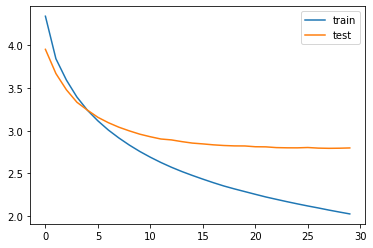

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [62]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [63]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [64]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [65]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [82]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and tar_index_to_word[i]!='sostoken'):
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [83]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former google asia pacific head free expression said google reported plan censored search engine china bad idea stupid move cannot see way operate google search china without violating human rights added google would reportedly blacklist sensitive issues like politics free speech democracy search 
실제 요약 : google plan of search in china stupid ex staffer 
예측 요약 :  google google search engine is not google ai ceo


원문 : real madrid footballer cristiano ronaldo earns crore instagram post study instagram claimed ronaldo third list highest instagram singer selena gomez kim kardashian ronaldo third highest number followers platform million people following 
실제 요약 : cristiano ronaldo earns cr per instagram post report 
예측 요약 :  ronaldo posts record of most ever ever fifa captain


원문 : lasting minutes july full moon would present longest total lunar eclipse st century event would primarily visible india africa middle east australia europe reason behind long duration moon would pass direc

예측 요약 :  us may pay billion to our oil loans us


원문 : mouthpiece saamana shiv sena monday said recent assassination threats pm narendra modi maharashtra cm devendra fadnavis nothing less plot horror story condemning matter added okay lakhs killed lakhs live 
실제 요약 : shiv sena calls plot to kill pm horror story 
예측 요약 :  pm modi is not just for andhra cm


원문 : group tinder co founders executives sued parent company match group controlling shareholder seeking least billion damages lawsuit claimed match deliberately dating app avoid paying billions dollars deprived employees stock options 
실제 요약 : tinder co founders sue parent match for at least billion 
예측 요약 :  startup sues us ceo for bn to sue him for ipo


원문 : international criminal court started investigation allegations crime humanity committed philippine president rodrigo duterte officials duterte philippine officials accused mass murder since began war drugs mayor nearly people killed war since duterte became president 
실제 요약 :

예측 요약 :  cbi files chargesheet against man who died in ryan murder


원문 : france rejected proposal made uk foreign secretary boris johnson build mile bridge across english channel rejecting offer french finance minister bruno le maire said several major european projects finish first johnson said ridiculous two countries linked single railway line 
실제 요약 : france rejects uk offer of mile bridge between them 
예측 요약 :  uk france may launch new york to solve brexit


원문 : moody downgraded yes bank ratings non investment grade changed outlook negative citing corporate governance concerns three yes bank directors including chairman ashok chawla resigned last two weeks resignations seen rbi directive restrict term ceo rana kapoor raised concerns corporate governance moody said 
실제 요약 : moody downgrades yes bank after three director 
예측 요약 :  rbi to hold interim yes bank for million


원문 : uk based automaker mclaren unveiled mclaren lt expected priced car comes twin engine give horsepower nm 

# 추출적 요약 


In [158]:
#텍스트를 입력하면 요약해서 요약텍스트를 리턴해주는 함수
def textSummaryAbs(text) :
    text_preprocess = preprocess_sentence(text)
    text_preprocess = src_tokenizer.texts_to_sequences([text])
    text_preprocess = pad_sequences(text_preprocess, maxlen=text_max_len, padding='post')
    summa = decode_sequence(text_preprocess)
    return summa
# textSummaryAbs(data_org['text'][0])
# print(data_org['headlines'][0])
# print("추출 요약 :", summarize(data_org['text'][0], ratio=0.5) )

전처리된 문장으로는 추출요약이 잘 되지 않아서 원본데이터를 다시 불러왔다

In [122]:
data_org = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [162]:
for i in range(50, 100):
    print("원문 :", data_org['text'][i] )
    print('\n')
    print("예측 요약 :", textSummaryAbs(data_org['text'][i]) )
    print("추출 요약 :", summarize(data_org['text'][i], ratio=0.5) )
    print("실제 요약 :", data_org['headlines'][i] )
    print('\n')
    print("-------------------------------------------------------")
    print('\n')

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


예측 요약 :  ex fm singh sinha detained in mumbai for loan fraud
추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL


-------------------------------------------------------


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and

예측 요약 :  vatican to probe sexual abuse of sexual abuse by
추출 요약 : A senior priest at the Vatican who handled cases of sexual abuse has quit after being accused of sexual abuse by a former nun.
실제 요약 : Vatican priest handling sex abuse cases quits over alleged sex abuse


-------------------------------------------------------


원문 : A 22-year-old writer turned down a job offer, claiming she was bullied to the point of tears during her two-hour interview by a UK company's CEO. Olivia Bland added the "brutal" interview brought back painful memories of her abusive relationship. "I am so sorry that anyone has been hurt, it is never my intent," Web Applications CEO Craig Dean replied. 


예측 요약 :  woman claims she was fired as ceo denies being hit by
추출 요약 : A 22-year-old writer turned down a job offer, claiming she was bullied to the point of tears during her two-hour interview by a UK company's CEO.
실제 요약 : Woman rejects job after CEO bullies her in interview; he apologises


-------------

예측 요약 :  toyota to make its first electric suv in
추출 요약 : Volkswagen's sales, including its MAN and Scania heavy trucks and buses, rose 0.9% to 10.83 million in 2018, the company had said.
실제 요약 : Volkswagen retains top spot in global sales, beats Toyota


-------------------------------------------------------


원문 : Ousted Nissan Chairman Carlos Ghosn has said his arrest over alleged financial misconduct was led by "plot and treason" by the Japanese carmaker's executives who opposed its deeper integration with Renault and Mitsubishi. Ghosn added he had discussed the integration plans with Nissan's CEO in September, a month before his arrest. He further said he wouldn't flee if granted bail.


예측 요약 :  nissan chairman faces arrest of nissan chairman
추출 요약 : Ousted Nissan Chairman Carlos Ghosn has said his arrest over alleged financial misconduct was led by "plot and treason" by the Japanese carmaker's executives who opposed its deeper integration with Renault and Mitsubishi.
실제 요약 : P

예측 요약 :  lord ram akbar will be good in up minister
추출 요약 : Gujarat Education Minister Bhupendrasinh Chudasma has written a congratulatory message to a yoga ashram run by rape-convict Asaram's organisation for observing February 14 as "Matru-Pitru Pujan Divas" (Mother-Father worship day).
실제 요약 : Minister praises rape-convict Asaram over Matru-Pitru Divas


-------------------------------------------------------


원문 : Venezuelan President NicolÃÂ¡s Maduro has claimed that his American counterpart Donald Trump ordered the Colombian government and the Colombian mafia to kill him. "If something happens to me, Trump and Colombian President IvÃÂ¡n MÃÂ¡rquez will bear responsibility," he added. The US has blamed Maduro for the economic crisis in Venezuela and recognised opposition leader Juan GuaidÃÂ³ as interim President.


예측 요약 :  trump slams trump for calling him protesters
추출 요약 : Venezuelan President NicolÃÂ¡s Maduro has claimed that his American counterpart Donald Trump ordered 

예측 요약 :  will not attend shah in the term amit shah
추출 요약 : He said the Opposition is thinking about leading the country but does not have a leader.
실제 요약 : Grand alliance, if wins, will see a new PM every day: Shah


-------------------------------------------------------


원문 : Prime Minister Narendra Modi on Wednesday said his government's demonetisation decision made houses affordable for the aspiring youth. He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector". He said 'UDAN' (Ude Desh ka Aam Nagrik) scheme has boosted the development of the country's aviation sector.


예측 요약 :  demonetisation to demonetisation pm modi
추출 요약 : He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".
실제 요약 : Demonetisation made homes affordable for youth: PM Modi


-------------------------------------------------------




# 추출요약과 예측 요약 비교
 추출 요약의 경우 원문의 일부 문장을 발췌해서 요약하는 것으로 보인다.  
 그에 따라 추출요약은 문법상 맞는 문장으로 이루어진 것으로 보인다.   
 하지만 핵심단어가 빠진 부분이 많이 보인다.
 원문에 따라 요약이 되지 않는 경우도 많이 있다.(짧거나 전처리를 거친 텍스트 이거나....)
   
 예측 요약의 경우 전처리를 거친 이후 요약을 했기에 단어의 나열로 표현되는 것 같은데,  
 생각보다는 문법상 많이 맞는 것 같다. 핵심단어를 좀 더 잘 포함한다.